In [ ]:
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import config
from utils import plotting, processing

In [ ]:
# suppress warnings from cartopy about downloading data
warnings.filterwarnings("ignore", message=".*Downloading.*", module="cartopy")

In [ ]:
config.REPO_ROOT

PosixPath('/home/users/skell/uor-msc-dissertation-xai-african-storms')

In [ ]:
df = pd.read_csv(
    config.DATA_DIR
    / "East_Africa_tracked_MCSs_2014_2019_longer_than_3_hours.csv"
)
df.head()

,Storm,Life,Area,Initial UTC,Lon,Lat,Parent,Child,Accreted,u,...,LonInBounds,LatInBounds,in_domain,areaxgpm_mean,duration,duration_hr,speed,mean_speed,east_africa_time,eat_hours
0,3992,13,25,2014-01-02 14:15:00,38.900739,6.77762,[-999],[-999],[-999],0.15,...,True,True,True,NaN,0 days 03:15:00,3.25,2.134379,4.309462,2014-01-02 17:15:00,17.25
1,3992,13,40,2014-01-02 14:15:00,38.854092,6.77762,[-999],[-999],[-999],0.03,...,True,True,True,69.239998,0 days 03:15:00,3.25,4.353582,4.309462,2014-01-02 17:30:00,17.50
2,3992,13,52,2014-01-02 14:15:00,38.854092,6.77762,[-999],[-999],[-999],0.04,...,True,True,True,61.460004,0 days 03:15:00,3.25,0.901467,4.309462,2014-01-02 17:45:00,17.75
3,3992,13,68,2014-01-02 14:15:00,38.854092,6.77762,[-999],[-999],[-999],-1.03,...,True,True,True,NaN,0 days 03:15:00,3.25,7.018408,4.309462,2014-01-02 18:00:00,18.00
4,3992,13,81,2014-01-02 14:15:00,38.806765,6.74383,[-999],[-999],[-999],-0.54,...,True,True,True,NaN,0 days 03:15:00,3.25,3.344515,4.309462,2014-01-02 18:15:00,18.25


In [ ]:
# sort dataframe by datetime and group by storm
storm_groups = df.sort_values(["Initial UTC"]).groupby("Storm")
storm_inits = storm_groups.first()

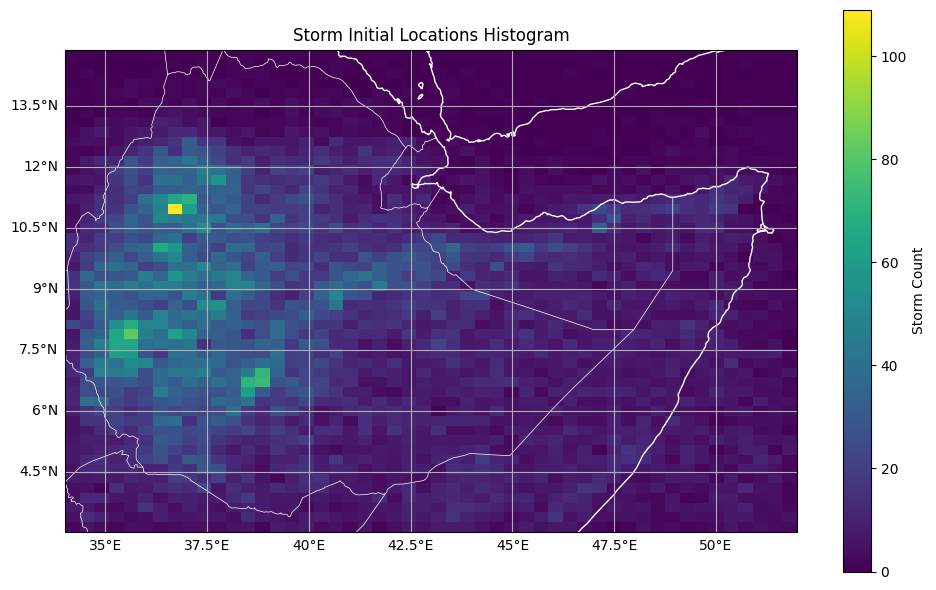

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map()
plotting.add_borders(ax, edgecolor="white")
plotting.add_gridlines(ax)

# https://www.julienphalip.com/blog/drawing-geographical-density-maps-with-matplotlib/
plt.hist2d(storm_inits["Lon"], storm_inits["Lat"], bins=50)
plt.colorbar(label="Storm Count")

plt.title("Storm Initial Locations Histogram")
plotting.save_plot("storm_init_hist2d.png")

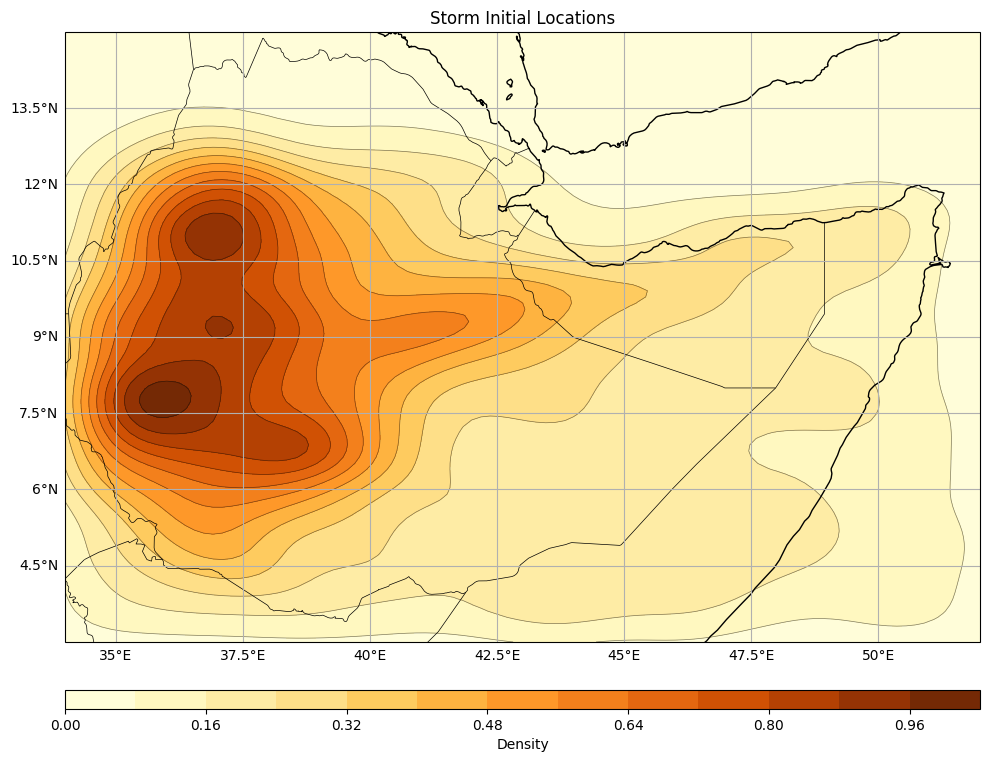

In [7]:
# 2D kernel density estimation
X, Y, Z = processing.calc_kde(storm_inits["Lon"], storm_inits["Lat"])

plt.figure(figsize=(10, 10))
ax = plotting.init_map()

# add filled contours and contour lines
plotting.plot_kde_map(X, Y, Z, ax=ax, colorbar_padding=0.05)

ax.set_title("Storm Initial Locations")
plotting.save_plot("storm_init_kde.png")

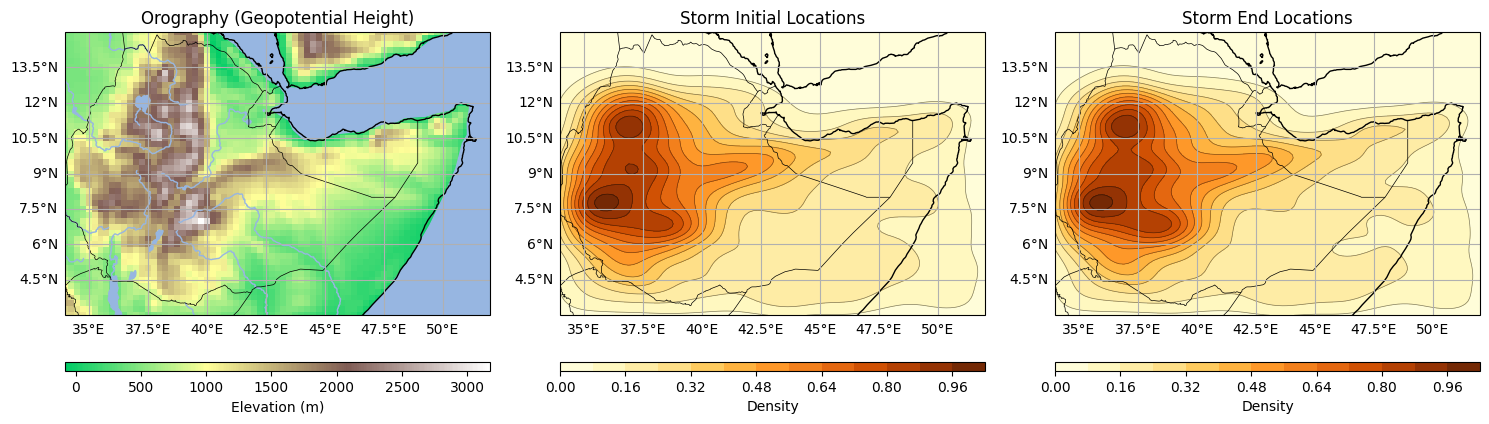

In [ ]:
fig, axs = plt.subplots(
    1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)

# plot the orography
plotting.init_map(axs[0], extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(axs[0], add_colorbar=True)
plotting.add_all_map_features(axs[0])
axs[0].set_title("Orography (Geopotential Height)")

# plot storm initial locations
storm_inits_x, storm_inits_y, storm_inits_kde = processing.calc_kde(
    storm_inits["Lon"], storm_inits["Lat"]
)
plotting.init_map(axs[1], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_inits_x, storm_inits_y, storm_inits_kde, ax=axs[1])
axs[1].set_title("Storm Initial Locations")

# plot storm end locations
storm_ends = storm_groups.last()
storm_ends_x, storm_ends_y, storm_ends_kde = processing.calc_kde(
    storm_ends["Lon"], storm_ends["Lat"]
)
plotting.init_map(axs[2], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_ends_x, storm_ends_y, storm_ends_kde, ax=axs[2])
axs[2].set_title("Storm End Locations")

plotting.save_plot("orography_storm_init_end_kde.png")

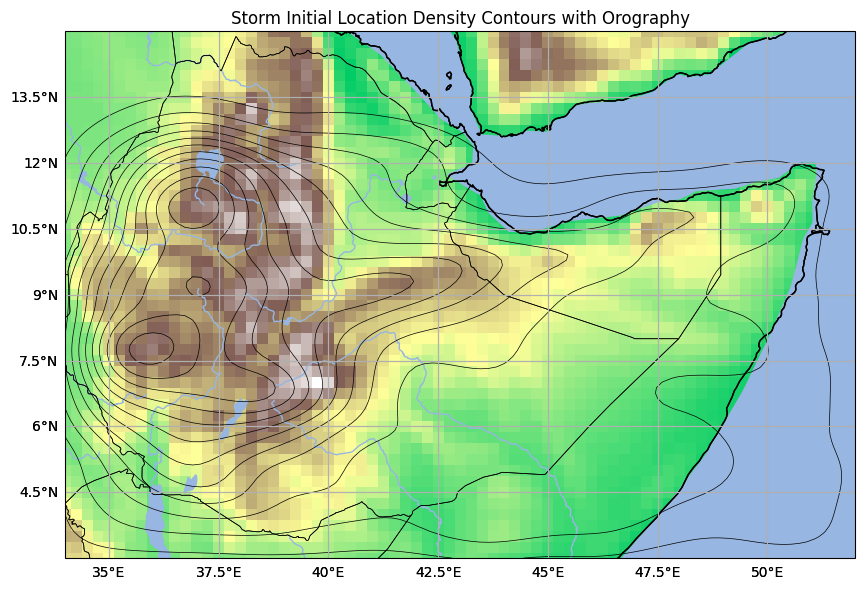

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map(extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(ax)
plotting.add_all_map_features(ax)

# plot storm initial locations kde contours
plotting.plot_kde_map(
    storm_inits_x,
    storm_inits_y,
    storm_inits_kde,
    ax=ax,
    contour_lines_only=True,
)

ax.set_title("Storm Initial Location Density Contours with Orography")
plotting.save_plot("orography_storm_init_locations.png")

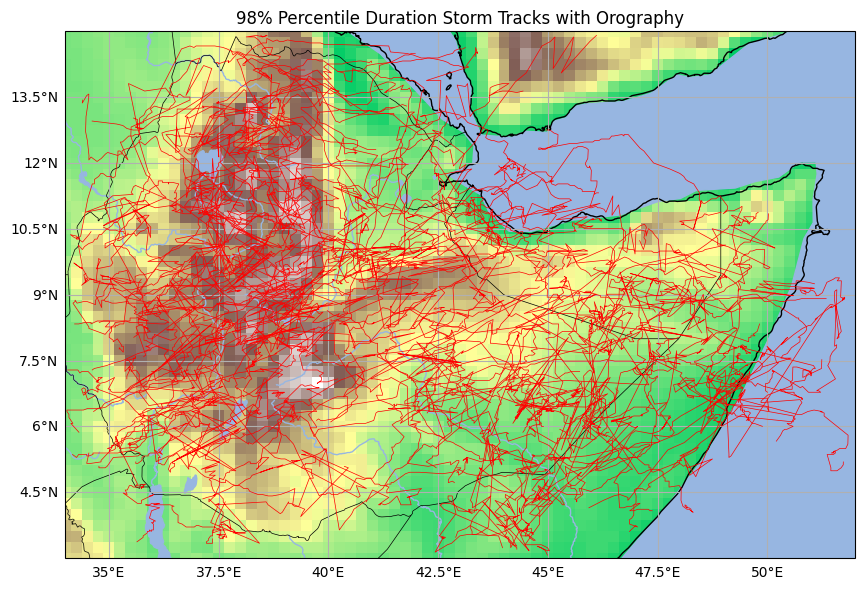

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map(extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(ax)
plotting.add_all_map_features(ax)

# plot storm tracks
# storm_ids = np.array(list(storm_groups.groups.keys()))
# storm_ids_sampled = np.random.choice(
#     storm_ids, size=int(0.1 * len(storm_ids)), replace=False
# )
# sampled_df = df[df["Storm"].isin(storm_ids_sampled)]
life_p95 = df["duration_hr"].quantile(0.98)
sampled_df = df[df["duration_hr"] >= life_p95].copy()
for storm, group in sampled_df.groupby("Storm"):
    ax.plot(
        group["Lon"],
        group["Lat"],
        color="red",
        linewidth=0.5,
        transform=ccrs.PlateCarree(),
    )

ax.set_title("98% Percentile Duration Storm Tracks with Orography")
plotting.save_plot("orography_storm_tracks_p98_duration.png")

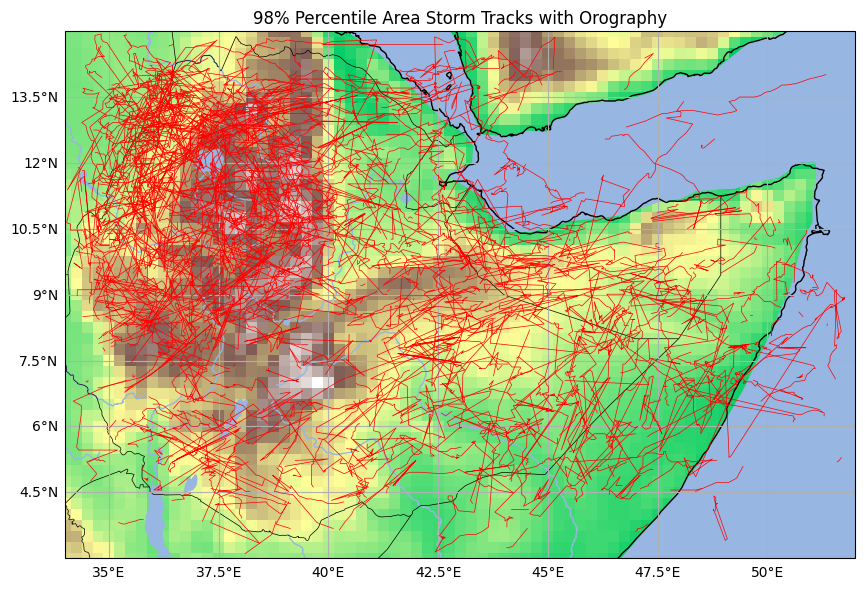

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map(extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(ax)
plotting.add_all_map_features(ax)

# plot storm tracks
# storm_ids = np.array(list(storm_groups.groups.keys()))
# storm_ids_sampled = np.random.choice(
#     storm_ids, size=int(0.1 * len(storm_ids)), replace=False
# )
# sampled_df = df[df["Storm"].isin(storm_ids_sampled)]
life_p95 = df["Area"].quantile(0.98)
sampled_df = df[df["Area"] >= life_p95].copy()
for storm, group in sampled_df.groupby("Storm"):
    ax.plot(
        group["Lon"],
        group["Lat"],
        color="red",
        linewidth=0.5,
        transform=ccrs.PlateCarree(),
    )

ax.set_title("98% Percentile Area Storm Tracks with Orography")
plotting.save_plot("orography_storm_tracks_p98_area.png")

In [ ]:
anor = xr.open_dataset(config.DATA_DIR / "anor_east_africa.nc")

In [13]:
anor

<xarray.Dataset> Size: 21kB
Dimensions:     (valid_time: 1, latitude: 57, longitude: 89)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2019-12-31T12:00:00
  * latitude    (latitude) float64 456B 16.0 15.75 15.5 15.25 ... 2.5 2.25 2.0
  * longitude   (longitude) float64 712B 31.0 31.25 31.5 ... 52.5 52.75 53.0
    expver      <U4 16B ...
Data variables:
    anor        (valid_time, latitude, longitude) float32 20kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-24T09:10 GRIB to CDM+CF via cfgrib-0.9.1...

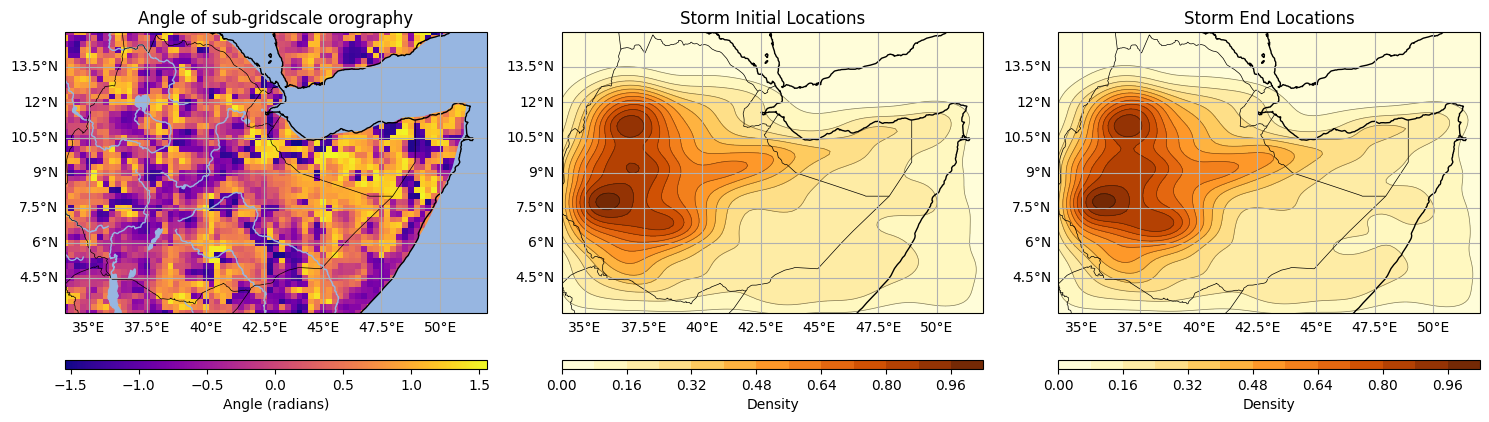

In [ ]:
fig, axs = plt.subplots(
    1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)

# plot the orography
plotting.init_map(axs[0], extent=config.STORM_DATA_EXTENT)
terrain = axs[0].pcolormesh(
    anor["longitude"],
    anor["latitude"],
    anor["anor"][0],
    cmap="plasma",
    transform=ccrs.PlateCarree(),
)
cbar = plt.colorbar(
    terrain, ax=axs[0], orientation="horizontal", pad=0.1, aspect=50
)
cbar.set_label("Angle (radians)")
plotting.add_all_map_features(axs[0])
axs[0].set_title("Angle of sub-gridscale orography")

# plot storm initial locations
storm_inits = storm_groups.first()
storm_inits_x, storm_inits_y, storm_inits_kde = processing.calc_kde(
    storm_inits["Lon"], storm_inits["Lat"]
)
plotting.init_map(axs[1], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_inits_x, storm_inits_y, storm_inits_kde, ax=axs[1])
axs[1].set_title("Storm Initial Locations")

# plot storm end locations
storm_ends = storm_groups.last()
storm_ends_x, storm_ends_y, storm_ends_kde = processing.calc_kde(
    storm_ends["Lon"], storm_ends["Lat"]
)
plotting.init_map(axs[2], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_ends_x, storm_ends_y, storm_ends_kde, ax=axs[2])
axs[2].set_title("Storm End Locations")

plotting.save_plot("anor_storm_init_end_kde.png")